# BAIT 509: Business Applications of Machine Learning
## Lecture 3 - Cross-validation, KNN, loess
Tomas Beuzen, 13th January 2020

# Lecture outline
- [0. Recap (5 mins)](#0)
- [1. Lecture learning objectives](#1)
- [2. Splitting your data and cross-validation (20 mins)](#2)
- [3. A conceptual introduction to kNN (5 mins)](#3)
- [4. Class Exercise: A toy example of kNN (10 mins)](#4)
- [5. kNN on a real dataset (10 mins)](#5)
- [--- Break --- (10 mins)](#break)
- [6. kNN regression (10 mins)](#6)
- [7. Loess/Lowess scatter smoothing (10 mins)](#7)
- [8. Class Exercise: hyperparameter optimization (20 mins)](#8)
- [9. What we've learned today (5 mins)](#9)
- [10. Summary questions to ponder](#10)

# 0. Recap  (5 mins) <a id=0></a>

- Difference between training and testing error
- Difference between irreducible and reducible error and the bias/variance tradeoff
- What are train/validation/test data sets and fundamental ML model development

# 1. Lecture learning objectives  <a id=1></a>

- Describe cross-validation and use `.cvscore()` to calculate cross-validation error
- Broadly describe how the kNN algorithm works.
- Discuss the effect of using a small/large value of the hyperparameter *k* when using the *k*NN algorithm.
- Discuss the difference between parametric and non-parametric machine learning models.

# 2. Splitting your data and cross-validation (15 mins) <a id=2></a>
- Last lecture we dicussed how there are usually 3 datasets involved in machine learning:
    1. **Training set**: used to learn the model
    2. **Validation set**: used to optimize the model (e.g., choose the best hyperparameters)
    3. **Testing set**: used to test the model (lock it in a "vault" until you're ready to test)
- But how does one choose these splits?
- Well, if you have a lots of data (1000/10,000/1,000,000 observations??? - "lots" depends on your problem) simple % splits are often enough:

<img src='./img/splits.png' width="400">

- A few rules of thumb:
    - We want a large enough training set to be able to develop a good model
    - We want a large enough validation/test set to get a good approximation of model performance on new data

### Problems with having a single train/test split
- Only using a portion of your full data set for training/testing (data is our most precious resource!!!)
- If your dataset is small you might end up with a tiny training/testing set
- Might be unlucky with your splits such that they don't well represent your data (shuffling data, as is done in `train_test_split()`, is not immune to being unlucky!)

### A solution: k-fold cross-validation
- $k$-fold cross-validation (CV) is one of the most common techniques used in practice
- Note that this $k$ is different to the $k$ in kNN! (just unfortunate coincidence of terminology)
- CV helps us combine the training/validation steps and use more data!
- Get a more "robust" measure of error on unseen data
- How it works:
    1. Split your data into k-folds ($k>2$, often $k=10$)
    2. Each "fold" gets a turn at being the validation set, while the other folds are used for fitting the model
    3. By this approach, we get $k$ prediction error estimates
    4. We then (typically) take the average of these $k$ estimates as our validation error

<img src='./img/cv.png' width="600">

- Cross-validation allows us to use more of our data during training/validation
- Typically we will split off a test set at the very start, and then use cross-validation to optimize our model

<img src='./img/cv2.png' width="600">

- We can use sklearn's `cross_validate()` to do cross-validation for us
- It is imported from the `model_selection` module
- We'll also import other libraries we need for this lecture while we're at it

In [1]:
from sklearn.model_selection import cross_validate # this is the cross-validation function

import numpy as np
import pandas as pd
import altair as alt
import sys
sys.path.append('code/')
from model_plotting import plot_model, plot_knn_grid, plot_lowess, plot_lowess_grid
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

- Let's load the cities data and split it into a train and test portion

In [2]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

In [3]:
X

,lon,lat
1,-80.162475,25.692104
2,-80.214360,25.944083
3,-80.094133,26.234314
4,-80.248086,26.291902
5,-81.789963,26.348035
...,...,...
396,-97.460476,48.225094
397,-96.551116,48.591592
398,-166.519855,53.887114
399,-163.733617,67.665859


In [4]:
y

,vote
1,blue
2,blue
3,blue
4,blue
5,blue
...,...
396,red
397,blue
398,red
399,red


- Now let's create a Decision Tree model with a `max_depth=3`

In [5]:
model = DecisionTreeClassifier(max_depth=3)

- Now we can use `cross_validate()` to do cross-validation
- Note that we don't have to call `.fit()` when using the function, it does it automatically for us
- We will do 5-fold cross-validation (i.e., $k$ = 5) using **only the training data**
- We should therefore get 5 results

- The `cv` argument can be used to specify how many folds of CV you want to do in `cross_validate()`
- The argument `return_train_score` is also useful, it will tell the functo to also return the training error
- The output of `cross_validate()` is a dictionary of useful information
- Note that the output is in terms of accuracy, and they call it `test_score` - although it is really `validation_score`

In [6]:
cv_score = cross_validate(model,
                          X_train,
                          y_train,
                          cv=5,
                          return_train_score=True)
cv_score

{'fit_time': array([0.00372314, 0.00313807, 0.00265193, 0.00234103, 0.00218391]),
 'score_time': array([0.00121498, 0.00093985, 0.00214505, 0.0007751 , 0.00081515]),
 'test_score': array([0.8125  , 0.78125 , 0.828125, 0.84375 , 0.859375]),
 'train_score': array([0.890625  , 0.87890625, 0.8515625 , 0.87109375, 0.86328125])}

- Typically we average the results of cross-validation to get an estimate of error
- This is our validation error

In [7]:
print(f"The mean cross-validation error is: {1 - cv_score['test_score'].mean():.2f}")

The mean cross-validation error is: 0.18


- Typically we will test different values of our hyperparameter(s)
- Then choose the one that gives the best mean cross-validation score
- But for now, let's just test our model on the test data

In [8]:
model.fit(X_train, y_train) # first fit the model
print(f"The test error is: {1 - model.score(X_test, y_test):.2f}")

The test error is: 0.19


- It's not unusual for out test error to be higher than our validation error
- We specifically chose the hyperparameter(s) that gave the lowest error on our training/validation data
- This doesn't mean they will give the lowest error on the test data (but we hope they do!)

# 3. A conceptual introduction to kNN (5 mins) <a id=3></a>

- Okay, it's time to learn a new algorithm!
- The k Nearest Neighbors (kNN) algorithm
- This is a fairly simple algorithm that is best understood by example
- Here is some toy data showing 2 features and 1 target (with 2 classes: <font color="blue">blue</font> and <font color="orange">orange</font>)
- I want to predict the point in grey

<img src='./img/scatter.png' width="400">

- An intuitive way to do this is predict the grey point using the same label as the next "closest" point (*k* = 1)
- We would predict a target of <font color="orange">**orange**</font> in this case

<img src='./img/scatter_k1.png' width="400">

- We could also use the 3 closest points (*k* = 3)...
- Of the 3 closest points, 1 is <font color="orange">**orange**</font>, 2 are <font color="blue">**blue**</font>
- We would therefore predict a target of <font color="blue">**blue**</font> in this case

<img src='./img/scatter_k3.png' width="400">

## 4. Class Exercise: A toy example of kNN (10 mins) <a id=4></a>

Consider this toy dataset:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

1. If $k=1$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$?
2. If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$?
3. If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$ if we were doing regression rather than classification?

- Now let's validate our answers using sklearn's kNN implementation
- The code below imports necessary libraries for this lecture
- It also creates the `X` and `y` data shown above

In [9]:
X = pd.DataFrame({'feature1': [5, 4, 2, 10, 9, 9],
                  'feature2': [2, 3, 2, 10, -1, 9]})
y = pd.DataFrame({'target': [0, 0, 1, 1, 1, 1]})

In [10]:
X

,feature1,feature2
0,5,2
1,4,3
2,2,2
3,10,10
4,9,-1
5,9,9


In [11]:
y

,target
0,0
1,0
2,1
3,1
4,1
5,1


- Now let's create a kNN classifier
- We can import the classifier from the `sklearn.neighbors` module

In [12]:
from sklearn.neighbors import KNeighborsClassifier

- And now we can create a model the same we've learned previously

In [13]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

/Users/tbeuzen/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


- An aside...
- What is that warning? It has to do with the data type (a dataframe) we are passing the the model
- The warning is telling us that sklearn is converting the dataframe to a 1D array (a vector)
- For the purpose of this lecture, I'm going to turn that warning off with the following code

In [14]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

- So let's do question 1 above
- Predict `x = [0, 0]`

In [15]:
knn.predict(np.atleast_2d([0, 0]))

array([1])

- How about for question 2 above
- Predict `x = [0, 0]` but this time with `k=3`

In [16]:
knn = KNeighborsClassifier(n_neighbors=3).fit(X, y)
knn.predict(np.atleast_2d([0, 0]))

array([0])

- Finally, question 3 requires to import the kNN regressor model
- We'll talk more about kNN regression later

In [17]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3).fit(X, y)
knn.predict(np.atleast_2d([0, 0]))

array([[0.33333333]])

# 5. kNN on a real dataset (10 mins) <a id=5></a>

- Let's reload the cities dataset to see how kNN performs on a real dataset

In [18]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]

- Let's use our code to plot up some different kNN models (with different k values)
- First we will do `k=1`

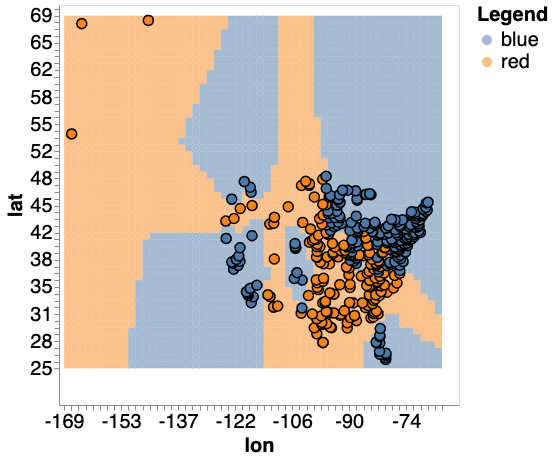

In [19]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)
plot_model(X, y, knn)

In [20]:
1 - knn.score(X, y)

0.0

- How about a larger `k`

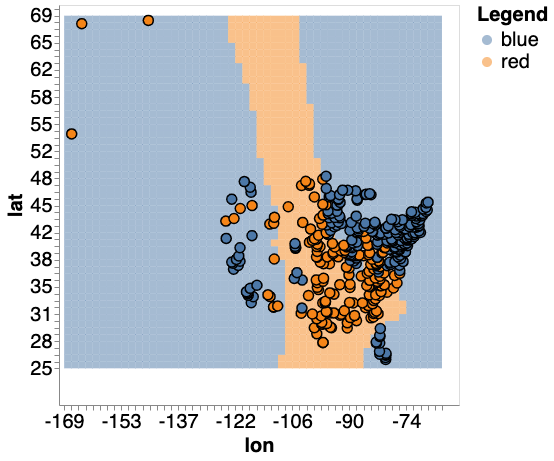

In [21]:
knn = KNeighborsClassifier(n_neighbors=20).fit(X, y)
plot_model(X, y, knn)

#### How does kNN relate to decision trees?
- Large *k* is "simple" like a decision stump
- It's not actually simple because we have to compare to a large number of observations!
- Small *k* is like a deep tree

# -------- Break (10 mins) -------- <a id="break"></a>

# 6. kNN regression (10 mins) <a id=6></a>
- In kNN regression we take the average of the *k* nearest neighbours
- Note: regression plots more naturally in 1D, classification in 2D, but of course we can do either for any $d$
- The code below creates some synthetic data and plots to help us visualise kNN regression
- We see that kNN regression is a way of average (smoothing) data to make predictions
- The higher the *k* the "smoother" the predictions

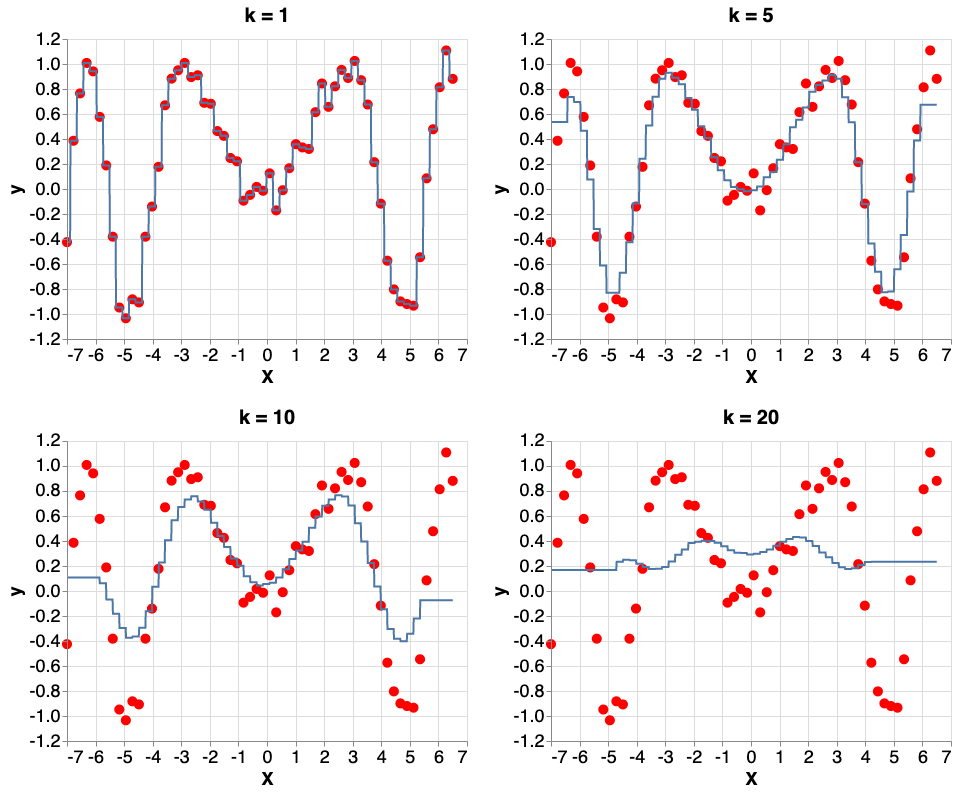

In [22]:
X = np.atleast_2d(np.linspace(-7, 6.5, 60)).T
y = (np.sin(X.T**2/5) + np.random.randn(60)*0.1).T
plot_knn_grid(X, y, k=[1, 5, 10, 20])

# 7. Loess/Lowess scatter smoothing (10 mins) <a id=7></a>
- Another approach for fitting a smooth curve through a set of data points
- Kind of like a combination of kNN and least squares regression
- But this [video](https://www.youtube.com/watch?v=Vf7oJ6z2LCc) provides an excellent explanation

<img src='./img/loess.png' width="500">

Source: [StatQuest](https://www.youtube.com/watch?v=Vf7oJ6z2LCc)

- We can import the lowess model from the statsmodel library as shown below

In [23]:
from statsmodels.nonparametric.smoothers_lowess import lowess

- Let's see how the model works for different $k$ values

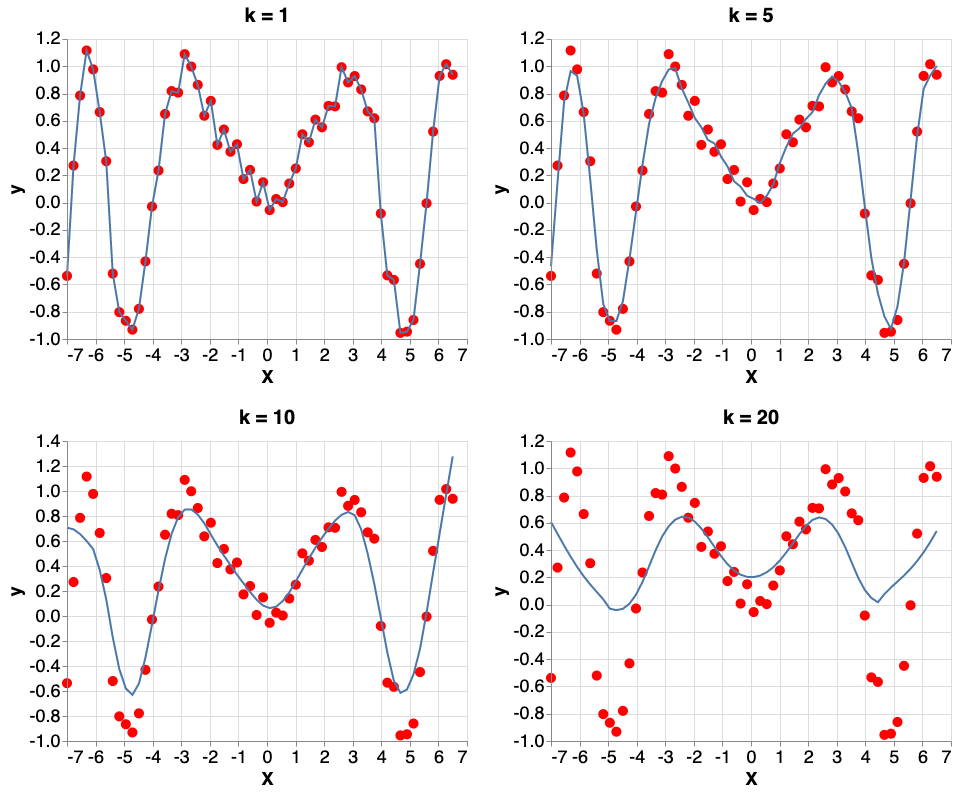

In [24]:
X = np.linspace(-7, 6.5, 60)
y = np.sin(X**2/5) + np.random.randn(60)*0.1
plot_lowess_grid(X, y, k=[1, 5, 10, 20])

# 8. Class Exercise: hyperparameter optimization (20 mins) <a id=8></a>

Using cross-validation is the standard way to optimize hyperparameters in ML model. We will practice that methodology here.

Your tasks:

1. Split the cities dataset into 2 parts using `train_test_split()`: 80% training, 20% testing.
2. Fit 5 different kNN classifiers to the training data (each with a different `k`).
3. Use 5-fold cross validation to get an estimate of validation error for each model.
4. Choose your best `k` value and fit a new model using the whole training data set.
5. Use this model to predict the test data. Is the error on the test data similar to the validation data?

# 9. What we've learned today <a id="9"></a>

- Cross-validation as a way of efficiently combining training/validation and choosing hyperparameters
- The kNN algorithm for classification and regression
- Lowess/loess smoothing 

# 10. Questions to ponder <a id="10"></a>

1. What happens if our data is of different scales?
2. How do we handle categorical data?